In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from category_encoders import OrdinalEncoder

from src.utils.logger import logger
from src.utils.io_utils import load_model, save_model

In [3]:
PARAMS = {'dim': 128,
          'window': 5,
          'min_count': 1,
          'negative_samp': 5,
          'epochs': 10,
          'seed': 42}

In [4]:
dataset = 'electronics'

### Load data

In [5]:
sequences = np.load('../data/{}_sequences.npy'.format(dataset))
# sequences = sequences.tolist()

In [6]:
val = pd.read_csv('../data/{}_edges_val.csv'.format(dataset))

In [7]:
meta = pd.read_csv('../data/{}_meta.csv'.format(dataset), dtype={'asin': 'object'})
meta.drop_duplicates(subset='asin', inplace=True)

In [9]:
word2id = load_model('../results/word2id_torch_emb_elec')
len(word2id)

2019-12-19 11:31:45,672 - Model loaded from: ../results/word2id_torch_emb_elec (Size: 57402775 bytes)


418749

In [10]:
logger.info('No. of rows in meta before filter by word2id: {}'.format(meta.shape[0]))
meta = meta[meta['asin'].isin(word2id.keys())].copy()
logger.info('No. of rows in meta after filter by word2id: {}'.format(meta.shape[0]))

2019-12-19 11:31:48,106 - No. of rows in meta before filter by word2id: 498196
2019-12-19 11:31:48,471 - No. of rows in meta after filter by word2id: 162023


In [13]:
83264/162023

0.5139023471976201

In [19]:
sum(meta['category_lvl_3'] == 'NA_VALUE')

2702

In [20]:
sum(meta['category_lvl_2'] == 'NA_VALUE')

0

In [12]:
meta.isnull().sum()

asin                  0
description       17672
categories            0
title              1040
price              3187
related               0
brand             83264
category_lvl_1        0
category_lvl_2        0
category_lvl_3        0
category_lvl_4        0
dtype: int64

In [10]:
meta['category_lvl_1'].value_counts()

electronics                  160688
cell phones & accessories      1320
automotive                        9
arts, crafts & sewing             2
beauty                            2
baby products                     1
clothing, shoes & jewelry         1
Name: category_lvl_1, dtype: int64

In [11]:
meta['category_lvl_2'].value_counts().head()

computers & accessories      70535
camera & photo               35203
accessories & supplies       24699
car & vehicle electronics    10471
portable audio & video        9163
Name: category_lvl_2, dtype: int64

In [12]:
meta['category_lvl_3'].value_counts().head()

audio & video accessories                18314
cables & accessories                     18293
accessories                              17191
touch screen tablet accessories          16531
laptop & netbook computer accessories    14315
Name: category_lvl_3, dtype: int64

In [13]:
meta['brand'].value_counts().head()

sony         1338
unknown      1265
generic      1139
dell          964
monoprice     953
Name: brand, dtype: int64

### Create features from meta

/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/eugeneyan/recsys/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0, 500)

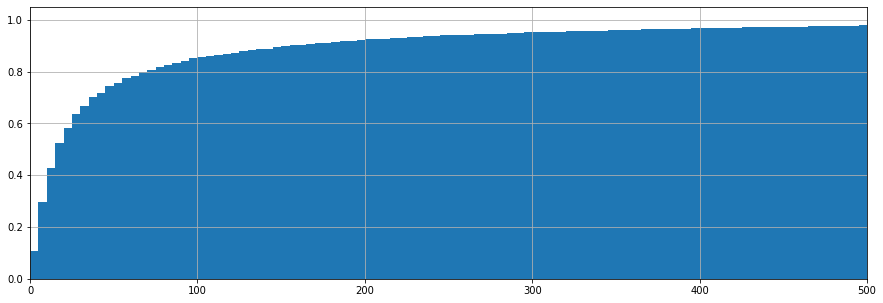

In [14]:
plt.figure(figsize=(15, 5))
plt.grid()
_ = plt.hist(meta['price'], bins=200, cumulative=True, normed=True)
plt.xlim((0, 500))

In [15]:
def round_up(num, divisor=5):
    return ((num + divisor-1) // divisor) * divisor

In [16]:
def bin_price(price):
    if price < 25:
        return price
    elif 25 < price < 50:
        return round_up(price, divisor=5)
    elif 50 < price < 500:
        return round_up(price, divisor=10)
    else:
        return 500

In [17]:
def prep_price(price_col):
    price = np.round(price_col)
    price.fillna(-1, inplace=True)
    price = price.astype(int)
    price = price.apply(bin_price)
    price = price + 1
    
    return price

In [18]:
meta['price'] = prep_price(meta['price'])

In [19]:
# Only keep books
meta = meta[meta['category_lvl_1'] == dataset].copy()

In [20]:
def prep_categorical(cat_col, min_threshold=100):
    counts = cat_col.value_counts()
    category_set = counts[counts > min_threshold].index
    
    return np.where(cat_col.isin(category_set), cat_col, 'MISC')

In [21]:
def prep_meta(meta):
    logger.info('No. of rows in meta before filter by word2id: {}'.format(meta.shape[0]))
    meta = meta[meta['asin'].isin(word2id.keys())].copy()
    logger.info('No. of rows in meta after filter by word2id: {}'.format(meta.shape[0]))
    
    meta['price'] = prep_price(meta['price'])
    meta['category_lvl_2'] = prep_categorical(meta['category_lvl_2'])
    meta['category_lvl_3'] = prep_categorical(meta['category_lvl_3'])
    meta['category_lvl_4'] = prep_categorical(meta['category_lvl_4'])
    meta['brand'] = prep_categorical(meta['brand'])
    
    return meta

In [22]:
meta = prep_meta(meta)

2019-12-05 18:00:22,557 - No. of rows in meta before filter by word2id: 160688
2019-12-05 18:00:22,817 - No. of rows in meta after filter by word2id: 160688


In [23]:
meta['category_lvl_1'].value_counts()

electronics    160688
Name: category_lvl_1, dtype: int64

In [24]:
meta['category_lvl_2'].value_counts().head()

computers & accessories      70535
camera & photo               35203
accessories & supplies       24699
car & vehicle electronics    10471
portable audio & video        9163
Name: category_lvl_2, dtype: int64

In [25]:
meta['category_lvl_3'].value_counts().head()

audio & video accessories                18314
cables & accessories                     18293
accessories                              17191
touch screen tablet accessories          16531
laptop & netbook computer accessories    14315
Name: category_lvl_3, dtype: int64

In [26]:
meta['category_lvl_4'].value_counts().head()

NA_VALUE                  16265
cases & sleeves           11481
cables & interconnects    10589
mp3 player accessories     5847
batteries & chargers       5804
Name: category_lvl_4, dtype: int64

In [27]:
meta['brand'].value_counts().head()

MISC       123011
sony         1336
unknown      1259
generic      1119
dell          964
Name: brand, dtype: int64

### Convert meta to dict

In [29]:
CAT_COLS = ['price', 'category_lvl_2', 'category_lvl_3', 'category_lvl_4', 'brand']
encoder = OrdinalEncoder(cols=CAT_COLS)
meta = encoder.fit_transform(meta)

In [36]:
meta[CAT_COLS].max() + 1

price              75
category_lvl_2     13
category_lvl_3     61
category_lvl_4    149
brand             131
dtype: int64

In [ ]:
def get_dict_values(meta):
    return [meta['price'], meta['category_lvl_2'], meta['category_lvl_3'], meta['category_lvl_4'], meta['brand']]

In [ ]:
def convert_meta_to_dict(meta):
    meta_cols = ['asin', 'price', 'category_lvl_2', 'category_lvl_3', 'category_lvl_4', 'brand']
    meta = meta[meta_cols].copy()
    
    # Encode to int
    CAT_COLS = ['price', 'category_lvl_2', 'category_lvl_3', 'category_lvl_4', 'brand']
    encoder = OrdinalEncoder(cols=CAT_COLS)
    meta = encoder.fit_transform(meta)
    save_model(encoder, '../model/encoder')
    
    meta['values'] = meta.apply(get_dict_values, axis=1)
    meta_dict = meta.set_index('asin')['values'].to_dict()
    meta_dict = {word2id[k]: v for k, v in meta_dict.items()}
    
    meta_counts_dict = meta[CAT_COLS].nunique().to_dict()
    
    return meta_dict, meta_counts_dict

In [ ]:
meta_dict, meta_counts_dict = convert_meta_to_dict(meta)

In [ ]:
meta_counts_dict

In [ ]:
def get_word_freq(sequences):
    # Flatten list
    seq_flat = list(itertools.chain.from_iterable(sequences))
    
    # Get word frequency
    word_freq = Counter(seq_flat)
    
    return word_freq

In [ ]:
word_freq = get_word_freq(sequences)

In [ ]:
def get_mapping_dicts(word_freq):
    word2id = dict()
    id2word = dict()

    wid = 0
    for w, c in word_freq.items():
        word2id[w] = wid
        id2word[wid] = w
        wid += 1
        
    return word2id, id2word

In [ ]:
word2id, id2word = get_mapping_dicts(word_freq)

In [ ]:
len(word2id)

### Add validation data into word2id

In [ ]:
val_product_set = set(val['product1'].values).union(set(val['product2'].values))

In [ ]:
len(val_product_set)

In [ ]:
wid = max(word2id.values()) + 1
for w in val_product_set:
    if w not in word2id:
        word2id[w] = wid
        id2word[wid] = w
        wid += 1

In [ ]:
len(word2id)

In [ ]:
def convert_sequence_to_id(sequences, word2id):
    return np.vectorize(word2id.get)(sequences)

In [ ]:
sequences = convert_sequence_to_id(sequences, word2id)

In [ ]:
sequences

In [ ]:
def convert_word_freq_to_id(word_freq, word2id):
    return {word2id[k]: v for k, v in word_freq.items()}

In [ ]:
word_freq = convert_word_freq_to_id(word_freq, word2id)

In [ ]:
def get_discard_probs(sequences, word_freq, sample=0.001):
    
    # Convert to array
    word_freq = np.array(list(word_freq.items()), dtype=np.float64)
    
    # Convert to probabilities
    word_freq[:, 1] = word_freq[:, 1] / word_freq[:, 1].sum()
    
    # Perform subsampling
    # http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
    word_freq[:, 1] = (np.sqrt(word_freq[:, 1]/sample) + 1)*(sample/word_freq[:, 1])
    
    # Get dict
    discard_probs = {int(k):v for k, v in word_freq.tolist()}
    
    return discard_probs

In [ ]:
discard_probs = get_discard_probs(sequences, word_freq)

In [ ]:
discard_probs[9]

In [ ]:
def get_negative_sample_table(sequences, word_freq, power=0.75):
    sample_table_size = 1e6
    
    # Convert to array
    word_freq = np.array(list(word_freq.items()), dtype=np.float64)
    
    # Adjust by power 
    word_freq[:, 1] = word_freq[:, 1] ** power
    
    # Get probabilities
    word_freq_sum = word_freq[:, 1].sum()
    word_freq[:, 1] = word_freq[:, 1] / word_freq_sum
    
    # Multiply probabilities by sample table size
    word_freq[:, 1] = np.round(word_freq[:, 1] * sample_table_size)
    
    # Convert to int
    word_freq = word_freq.astype(int).tolist()
    
    # Create sample table
    sample_table = [[tup[0]] * tup[1] for tup in word_freq]
    sample_table = np.array(list(itertools.chain.from_iterable(sample_table)))
    np.random.shuffle(sample_table)
    
    return sample_table

In [ ]:
neg_table = get_negative_sample_table(sequences, word_freq)

In [ ]:
def get_negative_samples(sample_size=5):
    negative_idx = 0
    # Get a batch from the shuffled table
    neg_sample = neg_table[negative_idx:negative_idx + sample_size]
    
    # Update negative index
    negative_idx = (negative_idx + sample_size) % len(neg_table)
    
    # Check if batch insufficient
    if len(neg_sample) != sample_size:
        neg_sample = np.concatenate((neg_sample, neg_samples[:negative_idx]))
        
    return neg_sample

In [ ]:
neg_samples = get_negative_samples()

### Get pairs (with subsampling)

In [ ]:
sequences

In [ ]:
sequence = sequences[1]
sequence

In [ ]:
# Works on per sequence
def get_pairs(idx, window=5):
    pairs = []
    sequence = sequences[idx]
    
    for center_idx, center in enumerate(sequence):
        for i in range(-window, window+1):
            context_idx = center_idx + i
            if context_idx > 0 and context_idx < len(sequence) and center != sequence[context_idx] and np.random.rand() < discard_probs[sequence[context_idx]]:
                context = sequence[context_idx]
                # pairs.append((center, context))
                center_meta = meta_dict.get(center, [0, 0, 0, 0, 0])
                context_meta = meta_dict.get(context, [0, 0, 0, 0, 0])
                pairs.append(([center] + center_meta, [context] + context_meta))
            
    return pairs

In [ ]:
get_pairs(1)

In [ ]:
def get_negative_samples(context, sample_size=5):
    negative_idx = 0
    while True:
        # Get a batch from the shuffled table
        neg_sample = neg_table[negative_idx:negative_idx + sample_size]

        # Update negative index
        negative_idx = (negative_idx + sample_size) % len(neg_table)

        # Check if batch insufficient
        if len(neg_sample) != sample_size:
            neg_sample = np.concatenate((neg_sample, neg_samples[:negative_idx]))
        
        if not context in neg_sample:
            return [[samp] + meta_dict.get(samp, [0, 0, 0, 0, 0]) for samp in neg_sample]

In [ ]:
sequences[1]

In [ ]:
pairs = get_pairs(1)
pairs[0]

In [ ]:
x_samp = get_negative_samples(26078)

In [ ]:
x_samp

In [ ]:
neg_samples = []
for center, center_meta, context, context_meta, in pairs:
    neg_samples.append(get_negative_samples(context))

neg_samples

In [ ]:
# # Works on batch
# def get_pairs(sequences, window=5):
#     pairs = []
#     window = PARAMS['window']

#     for sequence in sequences:
#         for center_idx, node in enumerate(sequence):
#             for i in range(-window, window+1):
#                 context_idx = center_idx + i
#                 if context_idx > 0 and context_idx < len(sequence) and node != sequence[context_idx] and np.random.rand() < discard_probs[sequence[context_idx]]:
#                     pairs.append((node, sequence[context_idx]))
                    
#     return pairs

In [ ]:
# pairs = get_pairs(sequences, PARAMS['window'])
# logger.info('Len of pairs: {:,}'.format(len(pairs)))

### Try sequence class

In [ ]:
from src.ml.data_loader_with_meta import Sequences, SequencesDataset
from torch.utils.data import DataLoader

In [ ]:
sequences = Sequences('../data/{}_sequences_samp.npy'.format(dataset), 
                      '../data/{}_edges_val_samp.csv'.format(dataset),
                      '../data/{}_meta.csv'.format(dataset))

In [ ]:
sequences.meta_dict

In [ ]:
pairs = sequences.get_pairs(0)
pairs

In [ ]:
neg_samples = []
for center, context in pairs:
    neg_samples.append(sequences.get_negative_samples(context))
neg_samples[:5]

In [ ]:
seq_dset = SequencesDataset(sequences)

In [ ]:
for i, batch in enumerate(seq_dset):
    logger.info(batch)
    if i > 3:
        break

In [ ]:
center = [pair[0] for pair in batch[0]]
context = [pair[1] for pair in batch[0]]
neg_context = batch[1]

In [ ]:
seq_dloader = DataLoader(dataset=seq_dset, batch_size=2, shuffle=False, collate_fn=seq_dset.collate)

In [ ]:
for i, batches in enumerate(seq_dloader):
    centers, contexts, neg_contexts = batches
    if i == 0:
        break

In [ ]:
batches[0]

In [ ]:
batches[1]

In [ ]:
batches[2]

### Init skipgram

In [ ]:
sequences.emb_size

In [ ]:
for 